In [1]:
import pandas as pd
import sqlite3
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Data Loading and Database Creation

Data is loaded from the UCI Machine Learning Repository and creates an SQLite database table to store the sensor data.

In [2]:
db_file="iot_failure.db"
data = fetch_ucirepo(id=601) 
X = data.data.features 
y = data.data.targets 
df = pd.concat([X, y], axis=1)

conn = sqlite3.connect(db_file,timeout=10)
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS iot_sensor_data (
UDI INTEGER PRIMARY KEY,
Product ID TEXT,
type TEXT,
air_temperature REAL,
process_temperature REAL,
rotational_speed INTEGER,
torque REAL,
tool_wear INTEGER,
machine_failure INTEGER,
twf INTEGER,
hdf INTEGER,
pwf INTEGER,
osf INTEGER,
rnf INTEGER
);
""")
df.to_sql("iot_sensor_data", conn, if_exists="replace", index=False)
conn.commit()


# Exploratory Data Analysis (EDA)
Perform basic EDA using SQL queries.

First 10 rows of Data

In [3]:
query="SELECT * from iot_sensor_data limit 10"
pd.read_sql(query, conn)

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


Get the count of records in the dataset

In [4]:
query_2="SELECT COUNT(*) AS total_records FROM iot_sensor_data;"
pd.read_sql(query_2, conn)

,total_records
0,10000


Average Values

In [5]:
#Transposed for readabilitys
query_3= """
SELECT 
    AVG("Air temperature") AS avg_air_temp,
    AVG("Process temperature") AS avg_process_temp,
    AVG("Rotational speed") AS avg_rotational_speed,
    AVG("Torque") AS avg_torque,
    AVG("Tool wear") AS avg_tool_wear,
    AVG("Machine failure") AS avg_machine_failure,
    AVG("TWF") AS avg_twf,
    AVG("HDF") AS avg_hdf,
    AVG("PWF") AS avg_pwf,
    AVG("OSF") AS avg_osf,
    AVG("RNF") AS avg_rnf
FROM iot_sensor_data;
"""
pd.read_sql(query_3, conn).T

,0
avg_air_temp,300.00493
avg_process_temp,310.00556
avg_rotational_speed,1538.77610
avg_torque,39.98691
avg_tool_wear,107.95100
avg_machine_failure,0.03390
avg_twf,0.00460
avg_hdf,0.01150
avg_pwf,0.00950
avg_osf,0.00980


Count of how many Machine Failures

In [6]:
query_4 = """
SELECT 
    "Machine failure", 
    COUNT(*) AS count,
    SUM("TWF") AS count_TWF,
    SUM("HDF") AS count_HDF,
    SUM("PWF") AS count_PWF,
    SUM("OSF") AS count_OSF,
    SUM("RNF") AS count_RNF
FROM iot_sensor_data 
GROUP BY "Machine failure";
"""
pd.read_sql(query_4, conn)

,Machine failure,count,count_TWF,count_HDF,count_PWF,count_OSF,count_RNF
0,0,9661,0,0,0,0,18
1,1,339,46,115,95,98,1


Average air temperature by product type

In [7]:
query_5= """
SELECT 
    "Type", 
    AVG("Air temperature") AS avg_air_temp 
FROM iot_sensor_data 
GROUP BY "Type";
"""
pd.read_sql(query_5, conn)

,Type,avg_air_temp
0,H,299.866999
1,L,300.015833
2,M,300.029263


Get the distribution of tool wear

In [8]:
query_6 = """
SELECT 
    "Tool wear", 
    COUNT(*) AS count 
FROM iot_sensor_data 
GROUP BY "Tool wear" 
ORDER BY "Tool wear";
"""
pd.read_sql(query_6, conn)

,Tool wear,count
0,0,120
1,2,69
2,3,34
3,4,34
4,5,63
...,...,...
241,242,2
242,244,3
243,246,3
244,251,1


Identify the maximum values recorded

In [9]:
query_7 = """
SELECT 
    MAX("Process temperature") AS max_process_temp,
    MAX("Rotational speed") AS max_rotational_speed,
    MAX("Torque") AS max_torque 
FROM iot_sensor_data;
"""
pd.read_sql(query_7, conn)

,max_process_temp,max_rotational_speed,max_torque
0,313.8,2886,76.6


# Data Visualization
Visualize data using Seaborn and Matplotlib

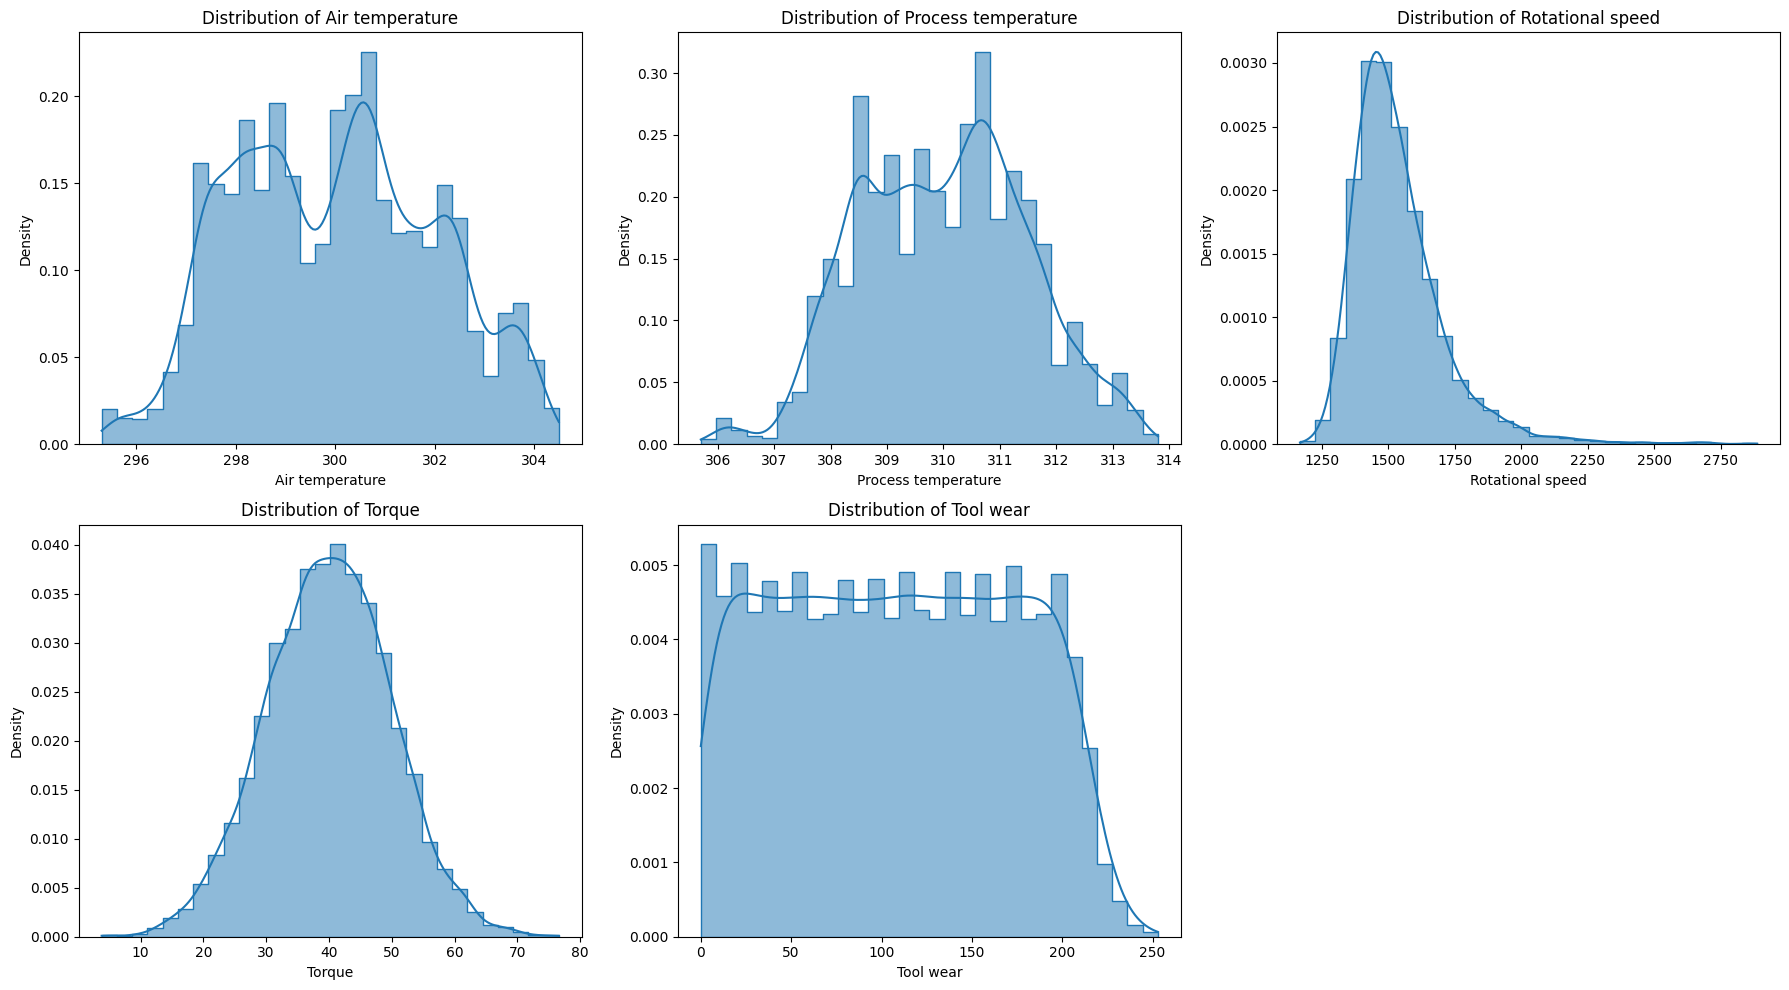

In [10]:
cols = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()  
for i, col in enumerate(cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], stat="density", element="step")
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

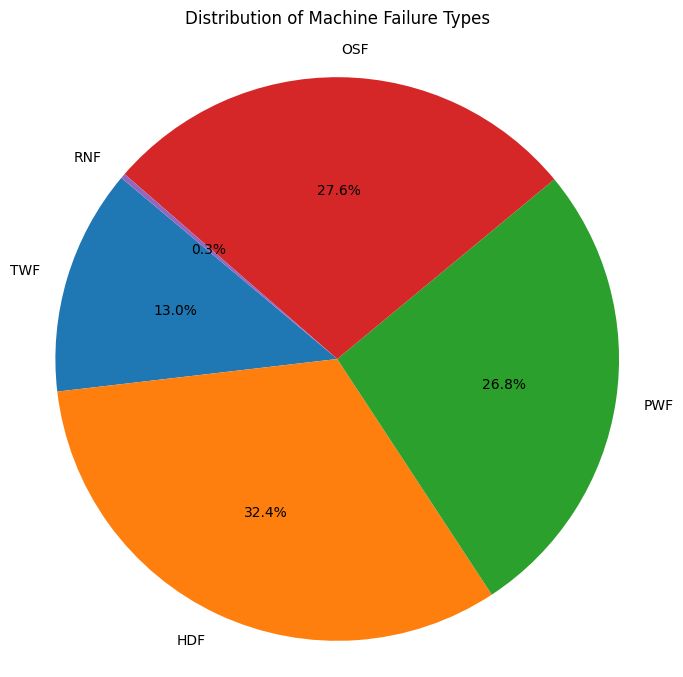

In [11]:
machine_failure_types=['TWF','HDF','PWF','OSF','RNF']
machine_failure_data = df[df['Machine failure'] == 1]
failure_counts = machine_failure_data[machine_failure_types].sum()

plt.figure(figsize=(8, 8), facecolor='white')
plt.pie(failure_counts, labels=failure_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Machine Failure Types', pad=20)
plt.axis('equal')  
plt.show()

<Figure size 1200x1000 with 0 Axes>

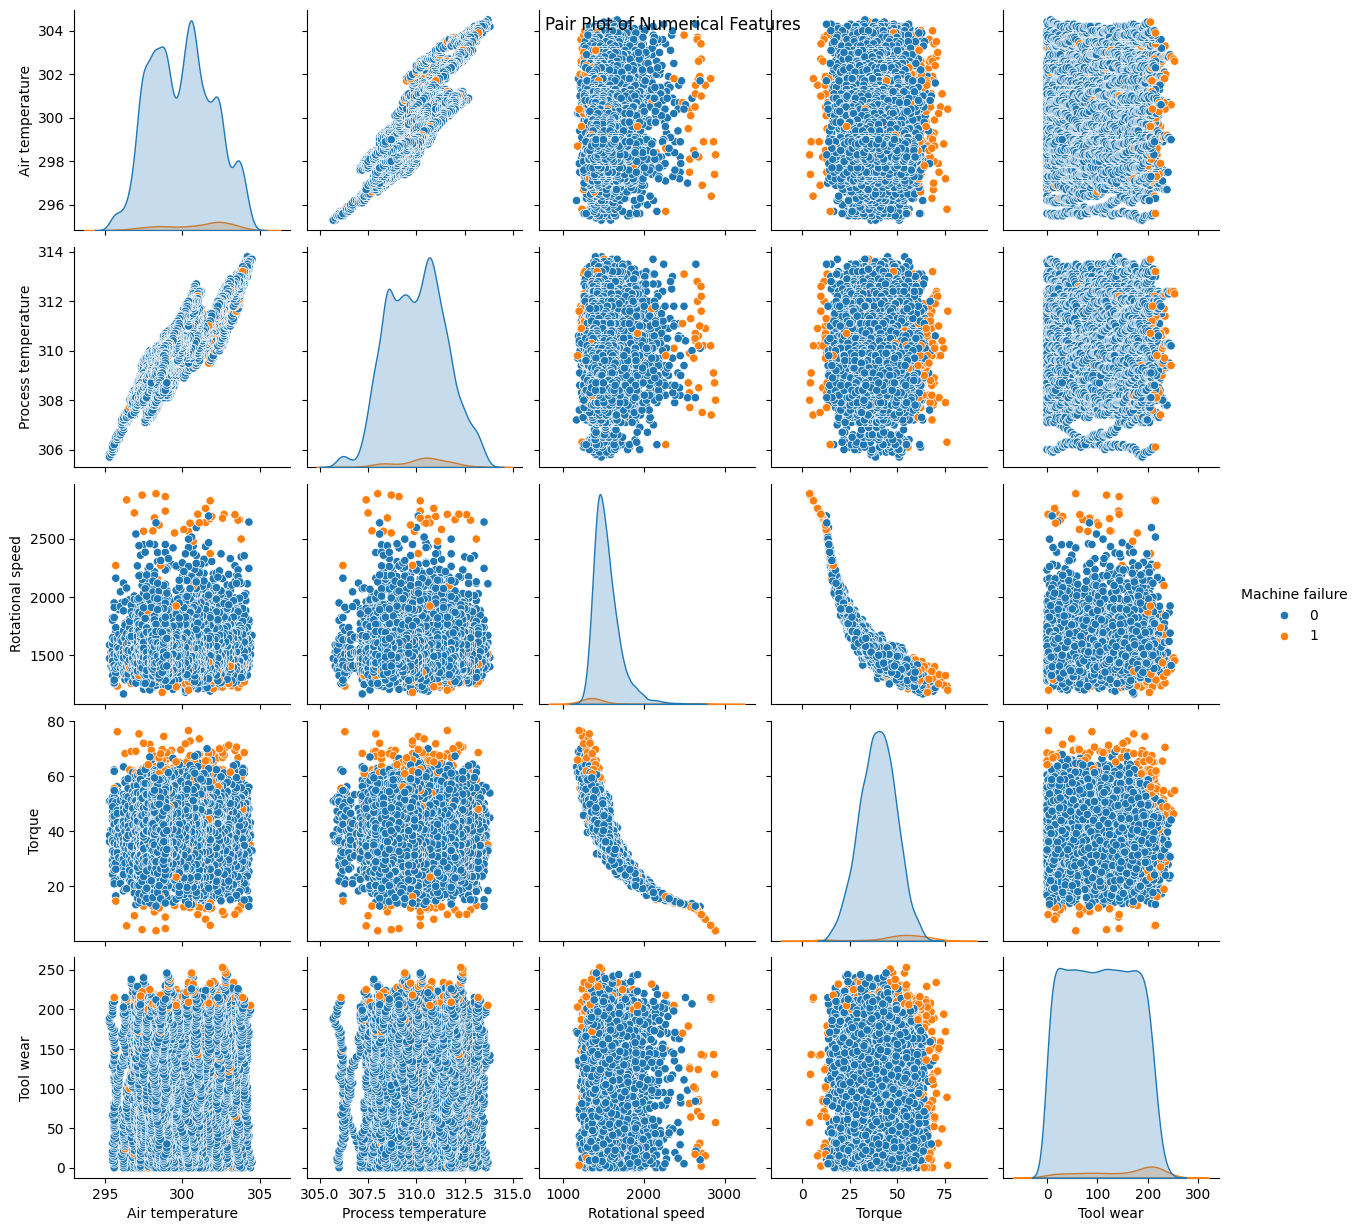

In [12]:
# Pair plot for numerical features
plt.figure(figsize=(12, 10))
sns.pairplot(df[cols + ['Machine failure']], hue='Machine failure')
plt.suptitle('Pair Plot of Numerical Features')
plt.show()

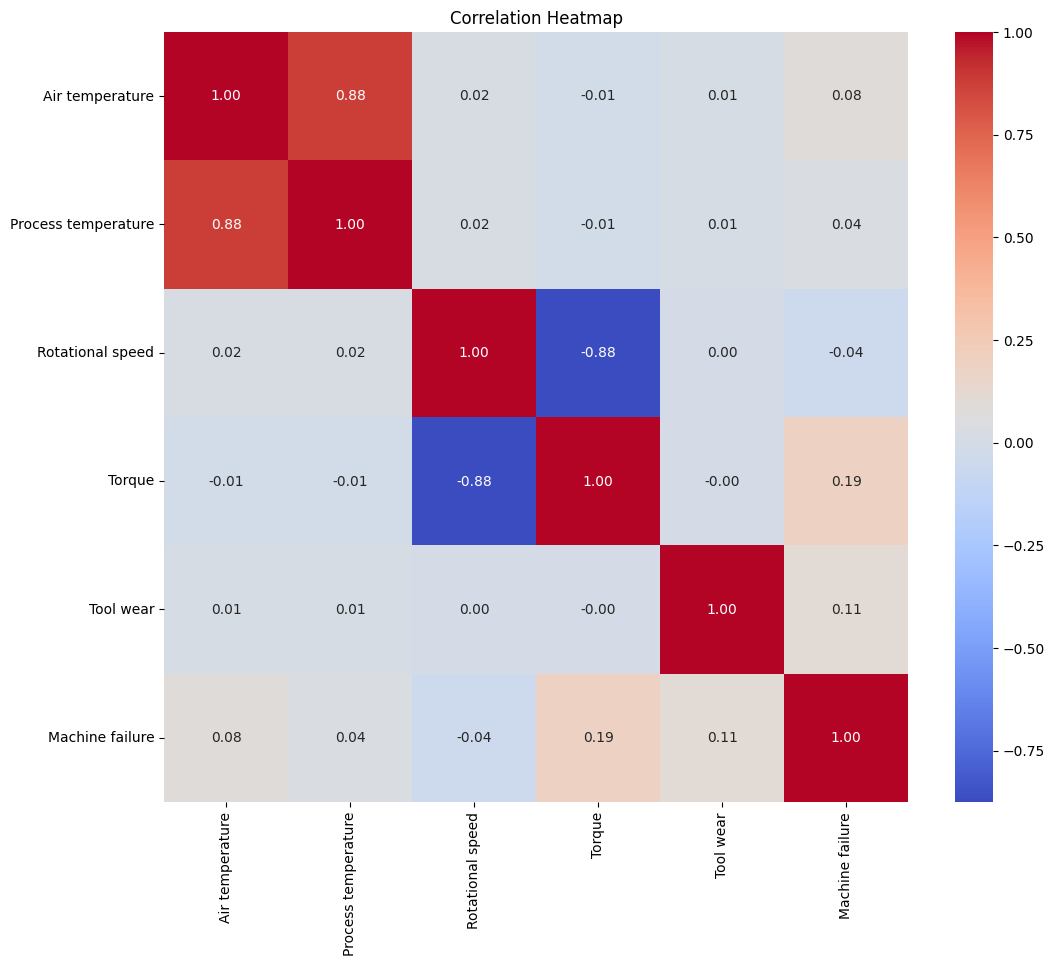

In [13]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[cols + ['Machine failure']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Text(0, 0.5, 'Process Temperature')

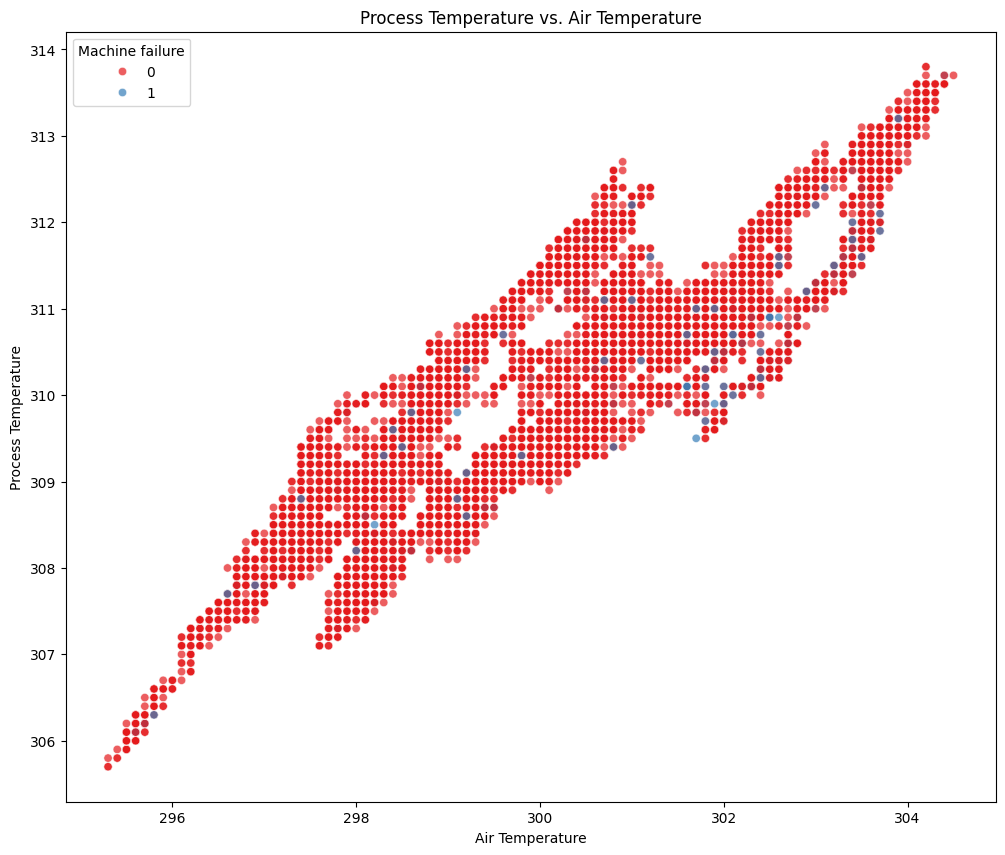

In [14]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='Air temperature', y='Process temperature', hue='Machine failure', alpha=0.7, palette='Set1')
plt.title('Process Temperature vs. Air Temperature')
plt.xlabel('Air Temperature')
plt.ylabel('Process Temperature')


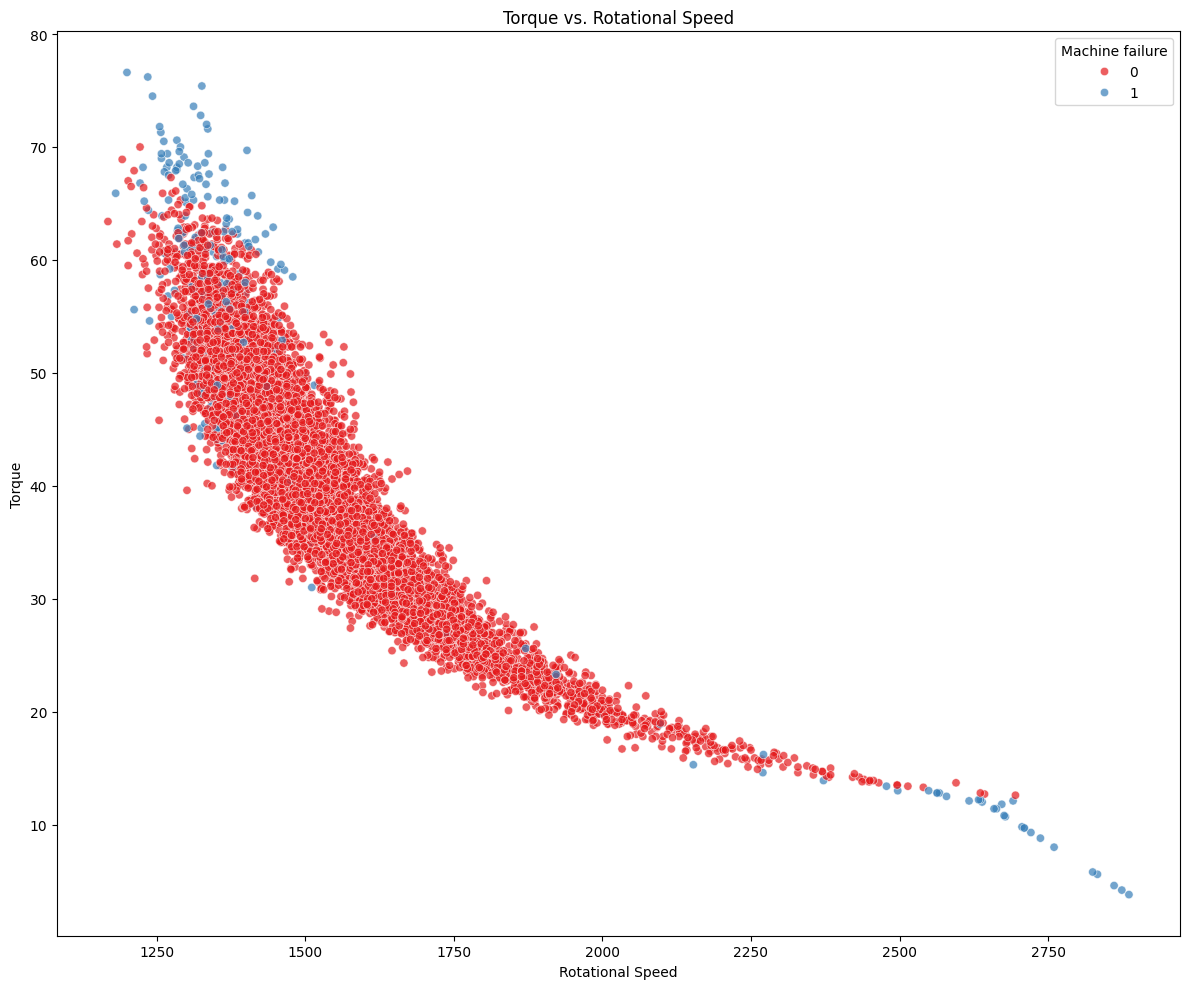

In [15]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='Rotational speed', y='Torque', hue='Machine failure', alpha=0.7, palette='Set1')
plt.title('Torque vs. Rotational Speed')
plt.xlabel('Rotational Speed')
plt.ylabel('Torque')

plt.tight_layout()
plt.show()

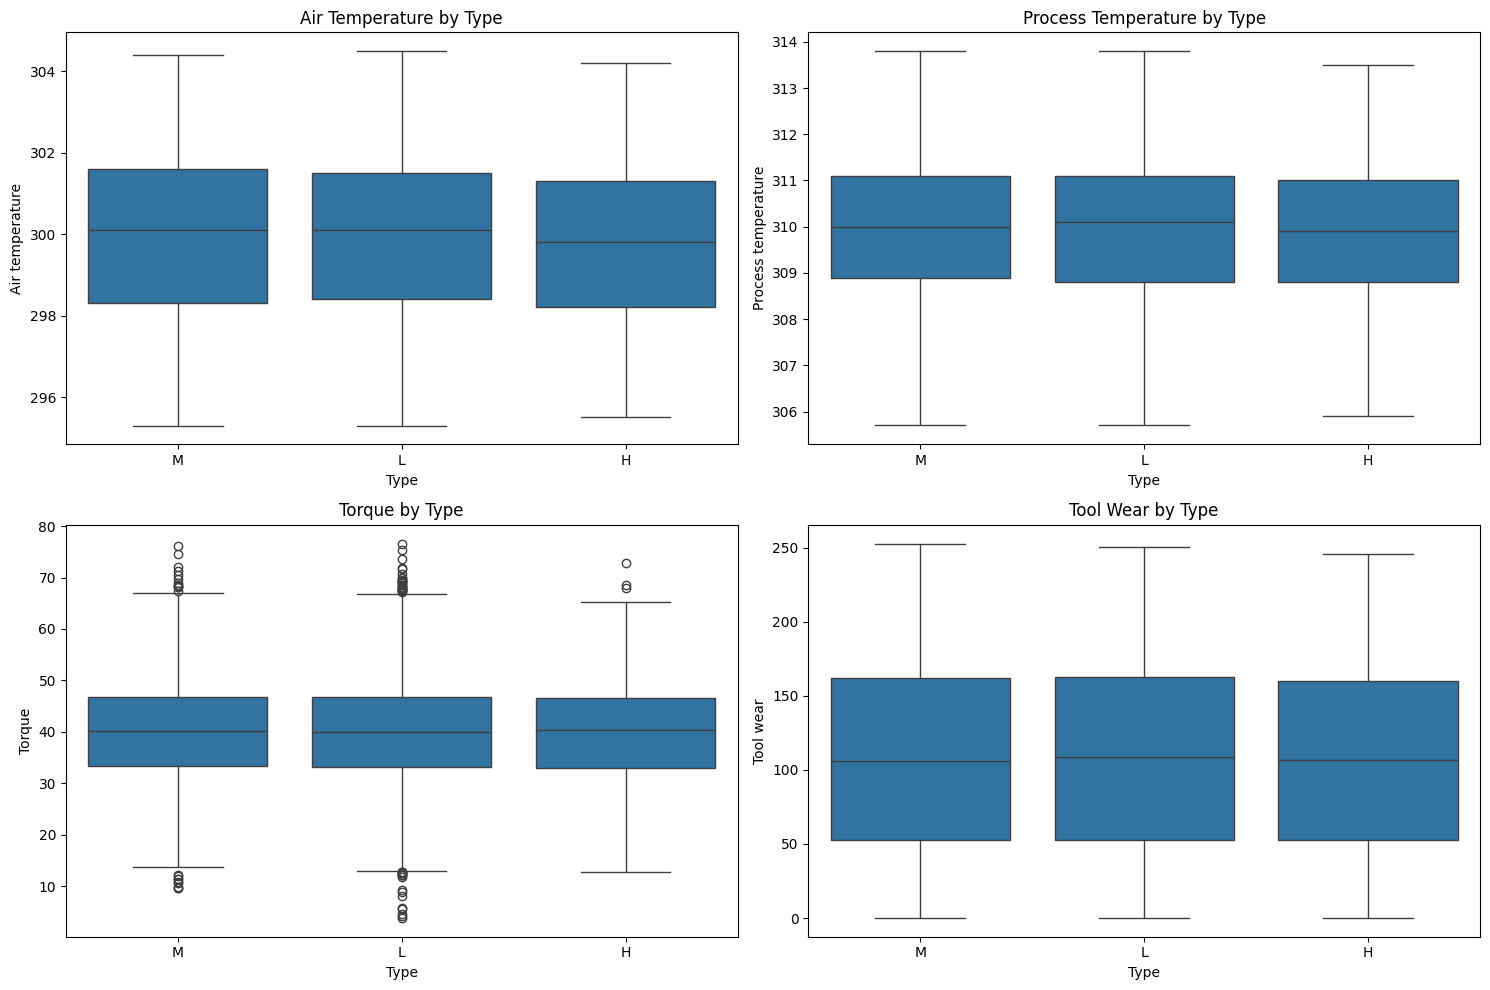

In [16]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='Type', y='Air temperature', data=df)
plt.title('Air Temperature by Type')

plt.subplot(2, 2, 2)
sns.boxplot(x='Type', y='Process temperature', data=df)
plt.title('Process Temperature by Type')

plt.subplot(2, 2, 3)
sns.boxplot(x='Type', y='Torque', data=df)
plt.title('Torque by Type')

plt.subplot(2, 2, 4)
sns.boxplot(x='Type', y='Tool wear', data=df)
plt.title('Tool Wear by Type')

plt.tight_layout()
plt.show()

# Data Preprocessing
1. Combining target variables
2. Label Encoding type
3. Removing outliers by IQR
4. Smote Oversampling
5. Standard scaling 

In [17]:
df['Target'] = 0  

df.loc[df['TWF'] > 0, 'Target'] = 1  
df.loc[df['HDF'] > 0, 'Target'] = 2  
df.loc[df['PWF'] > 0, 'Target'] = 3 
df.loc[df['OSF'] > 0, 'Target'] = 4  
df.loc[df['RNF'] > 0, 'Target'] = 5  
df.drop(columns=['Machine failure','TWF', 'HDF', 'PWF', 'OSF', 'RNF'], inplace=True)

In [18]:
label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])

In [19]:
Q1 = df['Torque'].quantile(0.25)
Q3 = df['Torque'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Torque'] >= lower_bound) & (df['Torque'] <= upper_bound)]

In [20]:
df.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0


In [21]:
X = df.drop(columns=['Target'])
y = df['Target'] 

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [22]:
scaler = StandardScaler()
scaled_features=scaler.fit_transform(X_resampled)
scaled_df = pd.DataFrame(scaled_features, columns=X_resampled.columns)

# Training and Testing Model

In [23]:
performance_metrics = {}
X_train, X_test, y_train, y_test = train_test_split(
    scaled_df,
    y_resampled,
    test_size=0.2, 
    random_state=42
)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  
    recall = recall_score(y_test, y_pred, average='weighted')       
    f1 = f1_score(y_test, y_pred, average='weighted')              
    
    performance_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

/Users/tusharchaudhry/Desktop/Predictive Maintenance/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Model Performance
The following table summarizes the performance of the classification models:

In [24]:
# Print the performance metrics in a formatted way
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("=" * 65)

for model_name, metrics in performance_metrics.items():
    print(f"{model_name:<25} {metrics['Accuracy']:<10.2%} {metrics['Precision']:<10.2%} {metrics['Recall']:<10.2%} {metrics['F1-Score']:<10.2%}")

Model                     Accuracy   Precision  Recall     F1-Score  
Logistic Regression       90.12%     89.79%     90.12%     89.88%    
Random Forest             99.27%     99.27%     99.27%     99.26%    
Support Vector Machine    96.35%     96.57%     96.35%     96.25%    
